# Healthcare Data

### Source: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/data

#### The data set consists of 1,338 rows of insurance data. Features included are Age, Sex, BMI, Number of Children, Smoker, Region, and Charges. 

In [481]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [482]:
df = pd.read_csv('/Users/Ethan_1/Documents/Tableau/insurance.csv')


In [483]:
print(df.head())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


#### The data appears to be in good shape for analysis. It will be helpful to add a dummy variable for the ‘Smoker’ feature, which will allow me to build regression models and view the correlations between the features. I might also create dummy variables for the ‘Region’ feature if my research questions necessitate it. Otherwise, I don’t foresee the need for any other major data transformations.

In [484]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


#### There are no null values and all of the data types look good. 

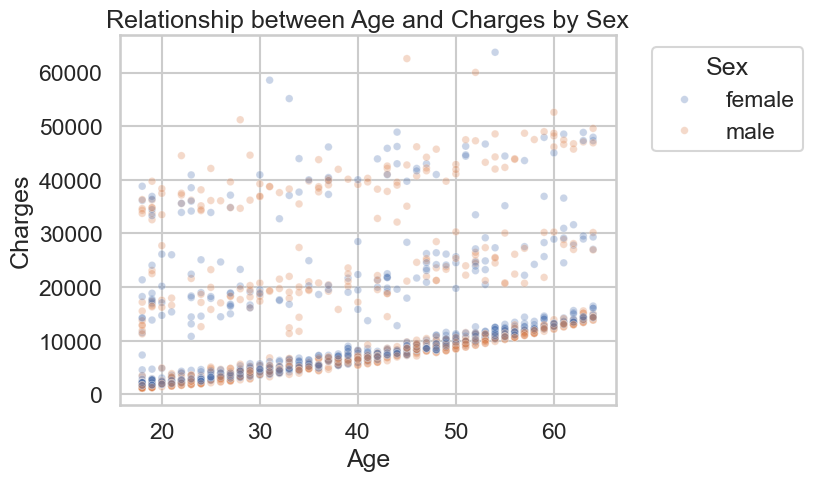

In [485]:

sb.set_style("whitegrid")

scatter_plot = sb.scatterplot(data=df, x='age', y='charges', hue='sex', alpha=0.3, palette='deep', s=30)

scatter_plot.set_title('Relationship between Age and Charges by Sex')
scatter_plot.set_xlabel('Age')
scatter_plot.set_ylabel('Charges')
scatter_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
scatter_plot.legend_.set_title("Sex")


#### I examined the relationship between age, charges, and sex to identify any interesting trends. As expected, healthcare charges tend to increase with age. An interesting observation is that the dispersion of charges for males and females is close when charges are low, but the bands widen as charges increase. Further analysis is needed to determine the significance of this observation.

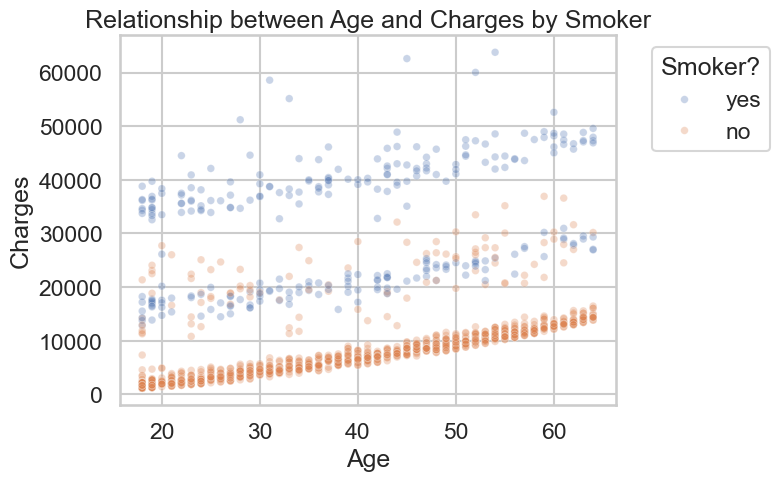

In [486]:
# Set the aesthetic style of the plots
sb.set_style("whitegrid")

# Set the context for the plots
sb.set_context("talk")

# Create the scatter plot
scatter_plot = sb.scatterplot(data=df, x='age', y='charges', hue='smoker', alpha=0.3, palette='deep', s=30)

# Set the title and labels
scatter_plot.set_title('Relationship between Age and Charges by Smoker')
scatter_plot.set_xlabel('Age')
scatter_plot.set_ylabel('Charges')
scatter_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
scatter_plot.legend_.set_title("Smoker?")

In [487]:
df['smoker'] = pd.get_dummies(df['smoker'], drop_first=True).astype(int)

In [488]:
print(df[['age', 'bmi', 'children', 'charges', 'smoker' ]].corr())

               age       bmi  children   charges    smoker
age       1.000000  0.109272  0.042469  0.299008 -0.025019
bmi       0.109272  1.000000  0.012759  0.198341  0.003750
children  0.042469  0.012759  1.000000  0.067998  0.007673
charges   0.299008  0.198341  0.067998  1.000000  0.787251
smoker   -0.025019  0.003750  0.007673  0.787251  1.000000


In [489]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


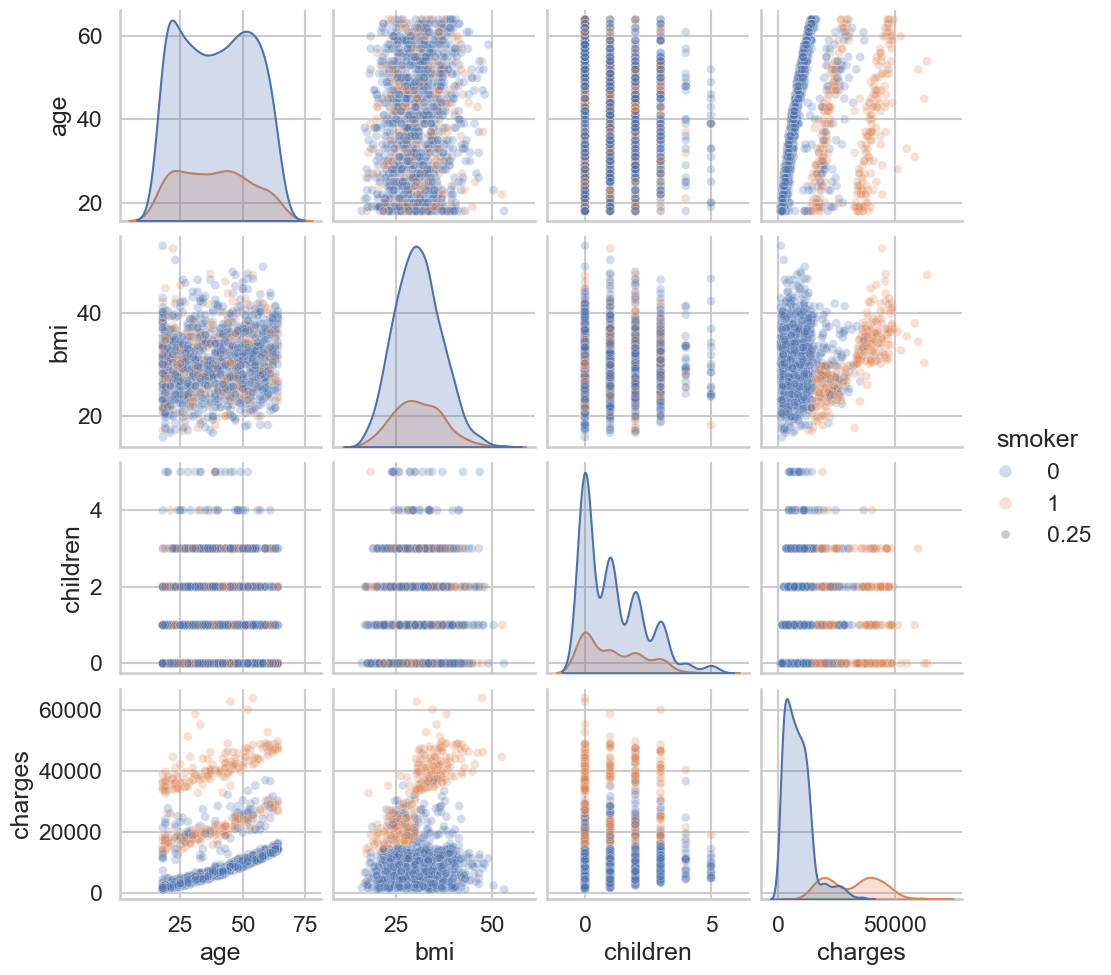

In [490]:
# Select the relevant columns
df_subset = df[['age', 'bmi', 'children', 'charges', 'smoker']]

# Create the pairplot
pair_plot = sb.pairplot(df_subset, hue='smoker', palette='deep', plot_kws={'alpha':0.25, 'size':.25})


## Question 1: Do smokers spend more money on healthcare on average?

### I will conduct hyptohosis testing to see if there is a statistically significant difference in the average amount smokers spend on health care compared to non-smokers.

In [491]:
smoker_mean_charges = round(df[df['smoker'] == 1]['charges'].mean(), 2)
print(f"Smoker Mean Charges: ${smoker_mean_charges}")

non_smoker_stdev_charges = round(df[df['smoker'] == 1]['charges'].std(), 2)
print(f"Smoker Std Dev Charges: ${non_smoker_stdev_charges}")

Smoker Mean Charges: $32050.23
Smoker Std Dev Charges: $11541.55


In [492]:
non_smoker_mean_charges = round(df[df['smoker'] == 0]['charges'].mean(), 2)
print(f"Non-smoker Mean Charges: ${non_smoker_mean_charges}")

non_smoker_stdev_charges = round(df[df['smoker'] == 0]['charges'].std(), 2)
print(f"Non-smoker Std Dev Charges: ${non_smoker_stdev_charges}")

Non-smoker Mean Charges: $8434.27
Non-smoker Std Dev Charges: $5993.78


### A/B Testing

#### I'll conduct basic hypothosis testing by creating two data frames, one for smokers and one for non-smokers. Then I'll use Scipy.stats to conduct a two-tailed test to see if the mean charges for smokers are infact different from the mean charges of non-smokers. 

In [493]:
smokers = df[df['smoker'] == 1]['charges']
non_smokers = df[df['smoker'] == 0]['charges']
t_stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False)
t_stat, p_value

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 32.751887766341824
p-value: 5.88946444671698e-103


#### With a t-statistic of 32.75 and a p-value of 5.89 * 10^-103 I can reject the null hypothosis. there is a statistically significant difference in healthcare charges for smokers compared to non-smokers

## Question 2: Is there a significant difference in the average BMI for smokers?

In [494]:
smokers = df[df['smoker'] == 1]['bmi']
non_smokers = df[df['smoker'] == 0]['bmi']
t_stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False)
t_stat, p_value

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 0.13352121947242343
p-value: 0.8938465511712552


#### Using a very similar approach the the previous A/B testing, I see that there is not a statistically significant difference in BMI between smokers and non-smokers in the data. I fail to reject the null hypothosis.

#### In order to accomodate additional analysis I'll create dummy variables for the 'sex' and 'region' features. This will enable me to consider these using techniques such as regression, k-means clustering, etc. 

In [495]:
region_dummies = pd.get_dummies(df['region'], drop_first= True).astype(int)
sex_dummies = pd.get_dummies(df['sex'], drop_first= False).astype(int)
region_dummies.head()

df.drop(['region', 'sex'], axis =1, inplace=True)


In [496]:
df = pd.concat([df, region_dummies, sex_dummies], axis=1)

df.head()

,age,bmi,children,smoker,charges,northwest,southeast,southwest,female,male
0,19,27.900,0,1,16884.92400,0,0,1,1,0
1,18,33.770,1,0,1725.55230,0,1,0,0,1
2,28,33.000,3,0,4449.46200,0,1,0,0,1
3,33,22.705,0,0,21984.47061,1,0,0,0,1
4,32,28.880,0,0,3866.85520,1,0,0,0,1


# Cluster Model

#### There are many reason to build cluster models for hrealthcare data. If I wanted to conduct segment analysis, improve resource allocation, or even improve predictive models; clusting can be an important tool for identifying underlying similarities in large maounts of data. 

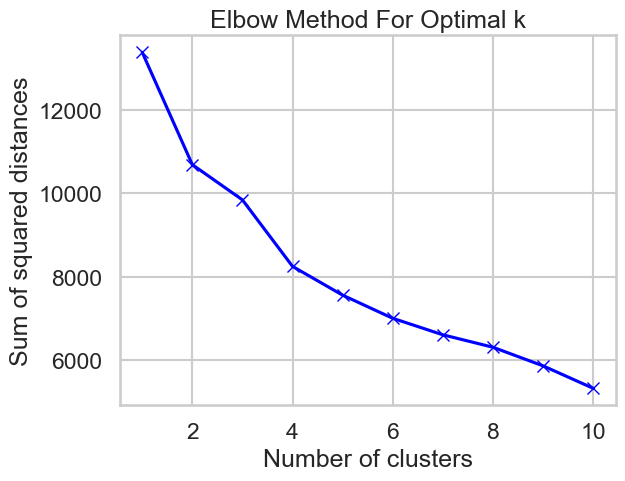

In [497]:
scaled_data = StandardScaler().fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_df)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [498]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)

df['cluster'] = kmeans.labels_

print(df.head())


cluster_means = df.groupby('cluster').mean()
print(cluster_means)

   age     bmi  children  smoker      charges  northwest  southeast  \
0   19  27.900         0       1  16884.92400          0          0   
1   18  33.770         1       0   1725.55230          0          1   
2   28  33.000         3       0   4449.46200          0          1   
3   33  22.705         0       0  21984.47061          1          0   
4   32  28.880         0       0   3866.85520          1          0   

   southwest  female  male  cluster  
0          1       1     0        0  
1          0       0     1        2  
2          0       0     1        2  
3          0       0     1        1  
4          0       0     1        1  
               age        bmi  children    smoker       charges  northwest  \
cluster                                                                      
0        39.334405  29.680723  1.093248  0.157556  11630.892064        0.0   
1        39.196923  29.199785  1.147692  0.178462  12417.575374        1.0   
2        39.012788  33.443184  1.

## Cluster Model Visualization

#### In order to visualize the results of the cluster model we'll have to reduce the dimensionality of the data to 2 using principle components analysis (PCA). 

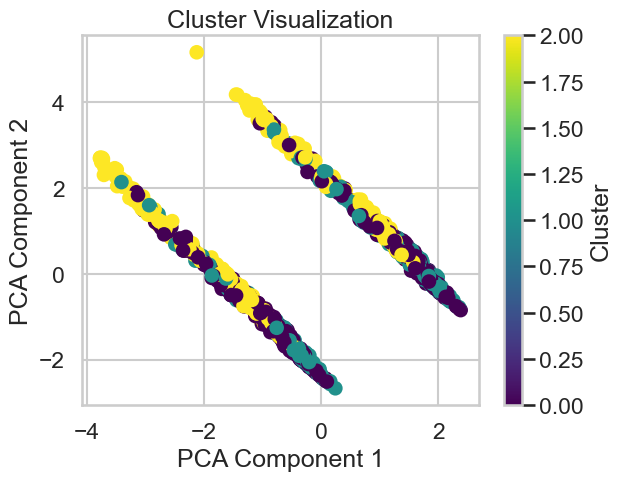

In [499]:

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)


plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()

#### Insights: 
- **Gender**:Gender and Smoking: Clusters 0 and 1 show that being a non-smoker results in lower medical charges, irrespective of gender. Cluster 2    indicates that smoking significantly increases medical charges. 
- **Region**:: The distribution across regions is relatively balanced, but the Southeast has a higher representation in Cluster 2. 
- **Medical Charges**:: Smoking is a major factor contributing to higher medical charges. Non-smokers, both male and female, have lower medical charges compared to smokers.

#### I'd like to see how different the results are if I exclude the 'smoker' feature in the training data. I'll follow a very similar process to the previous cluster model.

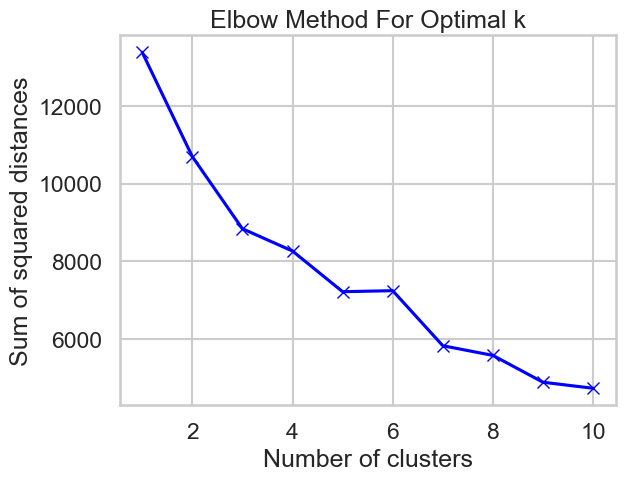

In [500]:

df_less_smoker = df.drop('smoker', axis =1)
scaled_data = StandardScaler().fit_transform(df_less_smoker)

scaled_df = pd.DataFrame(scaled_data, columns=df_less_smoker.columns)

sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_df)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Similar to the first model, the 'elbow' appears to be around the 3-4 cluster mark. We'll try 3 to start.

In [508]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)

df['cluster'] = kmeans.labels_

print(df.head())


cluster_means = df.groupby('cluster').mean()
print(cluster_means)

   age     bmi  children  smoker      charges  northwest  southeast  \
0   19  27.900         0       1  16884.92400          0          0   
1   18  33.770         1       0   1725.55230          0          1   
2   28  33.000         3       0   4449.46200          0          1   
3   33  22.705         0       0  21984.47061          1          0   
4   32  28.880         0       0   3866.85520          1          0   

   southwest  female  male  cluster  
0          1       1     0        0  
1          0       0     1        1  
2          0       0     1        1  
3          0       0     1        2  
4          0       0     1        2  
               age        bmi  children    smoker       charges  northwest  \
cluster                                                                      
0        39.456067  30.056297  1.092050  0.165272  11989.144610   0.000000   
1        39.012788  33.443184  1.053708  0.301790  16587.463250   0.000000   
2        39.115139  28.964670  1.

#### Insights
- **Region Influence**: Clusters show strong regional characteristics. Cluster 0 is mostly from the Southwest, Cluster 1 from the Southeast, and Cluster 2 from the Northwest.
- **Charges**: Cluster 1 has the highest medical charges, which correlates with higher BMI and higher smoking rate.
- **Gender Distribution**: Clusters show varying gender distributions, with Cluster 0 being predominantly female and Cluster 2 predominantly male.
- **Smoking Impact**: Although the smoker feature was excluded, the clusters still show that the highest average charges correlate with the highest smoking rate (Cluster 1).

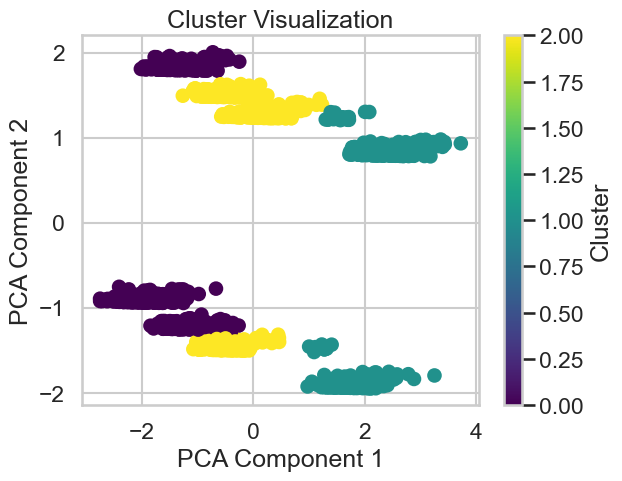

In [509]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)


plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()